In [ ]:
pip install torch==2.3.1
pip install transformers==4.43.4
pip install accelerate==0.33.0
pip install datasets==2.21.0
pip install peft==0.11.1
pip install bitsandbytes==0.43.1

# Agenda

1. [[Intro] Hugging Face and Transfer Learning](#Hugging_Face)
2. [[Theory] Intro to Generative Transformers](#gpt_intro)
3. [[Theory] Intro to Gemma2 models family](#gemma2_intro)
4. [[Theory] Parameter-efficient Fine-tuning (PEFT)](#peft)
5. [[Practice] Prompt engineering for fake news detection](#prompting)
6. [[Practice] QLoRA finetuning for fake news detection](#qlora_tuning)

<a id='Hugging_Face'></a>
# Hugging Face and Transfer Learning

It is a big community, which provides:
- The most popular Transformer repo - https://github.com/huggingface/transformers
- Hub with pre-trained models - https://huggingface.co/models
- Hub with datasets - https://huggingface.co/datasets
- Spaces - where you can publish your model or try other peoples' published models - https://huggingface.co/spaces
- Some commercial solutions

## Transfer Learning (in a short)

Original article - https://machinelearningmastery.com/transfer-learning-for-deep-learning/

**What does it mean "Pre-trained models" ???**

Lets take a look at the concept of Transfer Learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

### Pipeline how to use Transfer Learning


1. **Select Source Model.** A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.
2. **Reuse Model.** The pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.
3. **Tune Model.** Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.

### Tranfer Learning Use-Cases

- **Transfer Learning with Image Data:** For example this may be a prediction task that takes photographs or video data as input. For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the [ImageNet](https://image-net.org/) 1000-class photograph classification competition. This approach is effective because the images were trained on a large corpus of photographs and require the model to make predictions on a relatively large number of classes, in turn, requiring that the model efficiently learn to extract features from photographs in order to perform well on the problem.
- **Transfer Learning with Language Data:** It is common to perform transfer learning with natural language processing problems that use text as input or output. For these types of problems, a word embedding is used. It is just a mapping of words to a high-dimensional continuous vector space where different words with a similar meaning have a similar vector representation. Pre-trained models are mostly trained on Language modelling tasks, so they should keep well structed context information in their word embeddings.

### Benefits from Transfer Learning


1. **Higher start.** The initial skill (before refining the model) on the source model is higher than it otherwise would be.
2. **Higher slope.** The rate of improvement of skill during training of the source model is steeper than it otherwise would be.
3. **Higher asymptote.** The converged skill of the trained model is better than it otherwise would be.

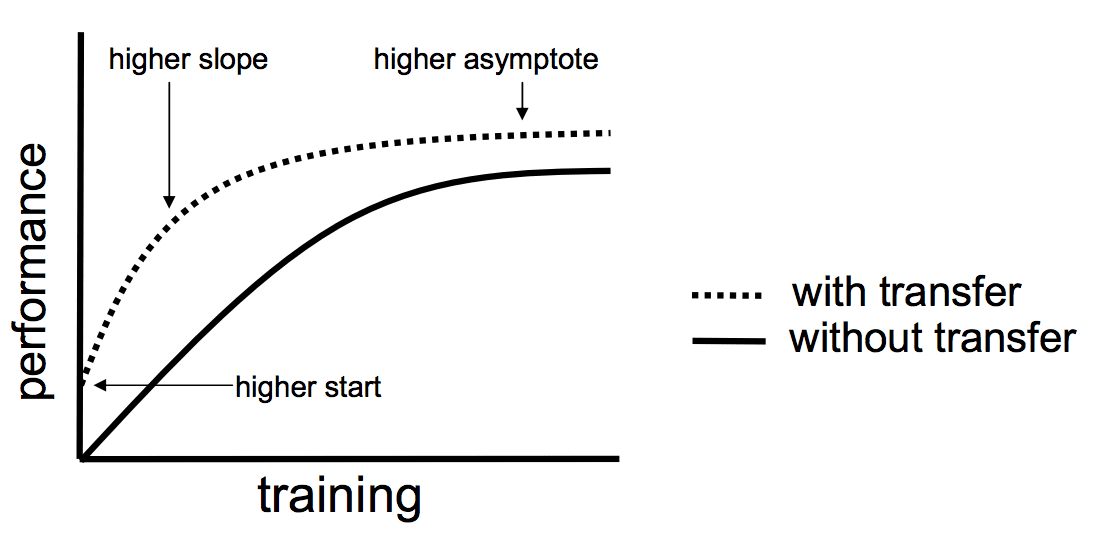

### Naive Intuition: Why does Transfer Learning work ?

Transfer learning "can be called" an inductive transfer. This is where the scope of possible models (model bias) is narrowed in a beneficial way by using a model fit on a different, but related task.

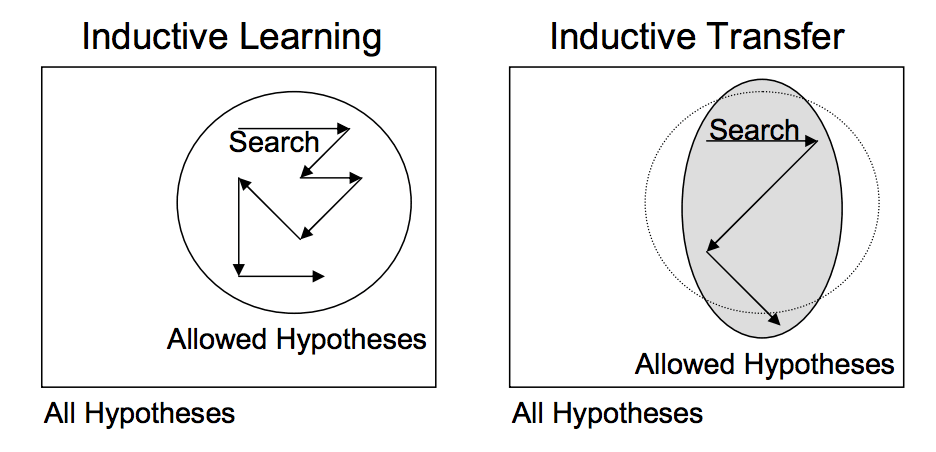

## Language Modelling

Language modeling is the task of predicting the next word or character in a document. This technique can be used to train language models that can further be applied to a wide range of natural language tasks like text generation, text classification, and question answering. 

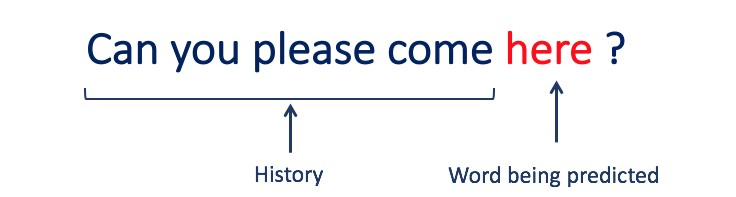

> **TODO**: Read about mathematical background of language modelling https://en.wikipedia.org/wiki/Language_model. Probability Theory works pretty cool there!

<a id='gpt_intro'></a>
# [Theory] Intro to Generative Transformers

> **TODO:** Check the [lecture](https://github.com/VSydorskyy/iasa_nlp_course/blob/main/Lecture_6/lecture_6_lp.ipynb) about generative models 

---
**Generative pre-trained transformers (GPT)** models are **decoder-only** Transformer models. In the original ["Attention is All You Need" paper](https://arxiv.org/pdf/1706.03762.pdf) that introduced the Transformer architecture, the model was presented as an encoder-decoder architecture. However, in the case of GPT models, the encoder component is omitted, and only the decoder stack is used.


### Auto-regressive generation

Approach when model generates text or language sequentially, word by word or token by token, with each word being dependent on the preceding words in the sequence is called auto-regressive. This approach is "auto-regressive" because the model uses its own previously generated words as context to predict and generate the next word. 

Auto-regressive language generation is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions:
$$\large P(w_{1:T}|W_0) = \prod_{t=1}^T P(w_t|w_{1:t-1}, W_0),\;with\;w_{1:0}=∅$$

and $W_0$ being the initial context word sequence.

The length $T$ of the word sequence is usually determined on-the-fly and corresponds to the timestep $t=T$ the `<EOS>` token is generated from $P(w_t|w_{1:t-1}, W_0)$.

![ar](../images/text-gen-diagram.png)


The GPT model is performing autoregressive text generation. In this context, they operate solely as decoders, producing text one word at a time based on the preceding context. This makes them well-suited for tasks like text completion, text generation, and natural language understanding.

### Ways of selecting tokens
#### Greedy search

Greedy search is the simplest decoding method. It selects the word with the highest probability as its next word $w_t=argmax_w P(w∣w_{1:t−1})$ at each timestep $t$.

![](../images/greedy_search.png)

The major drawback of greedy search though is that it misses high probability words hidden behind a low probability word as can be seen in our sketch above:

#### Sampling

Sampling means randomly picking the next word $w_t$ according to its conditional probability distribution:

$$\large w_t∼P(w ∣ w_{1:t−1})$$

We can further improve this by modifing the pool of words we use for it, or by weighting the probabilities of words e.g. using softmax temprature <br>

$$ \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} $$ <br><br>
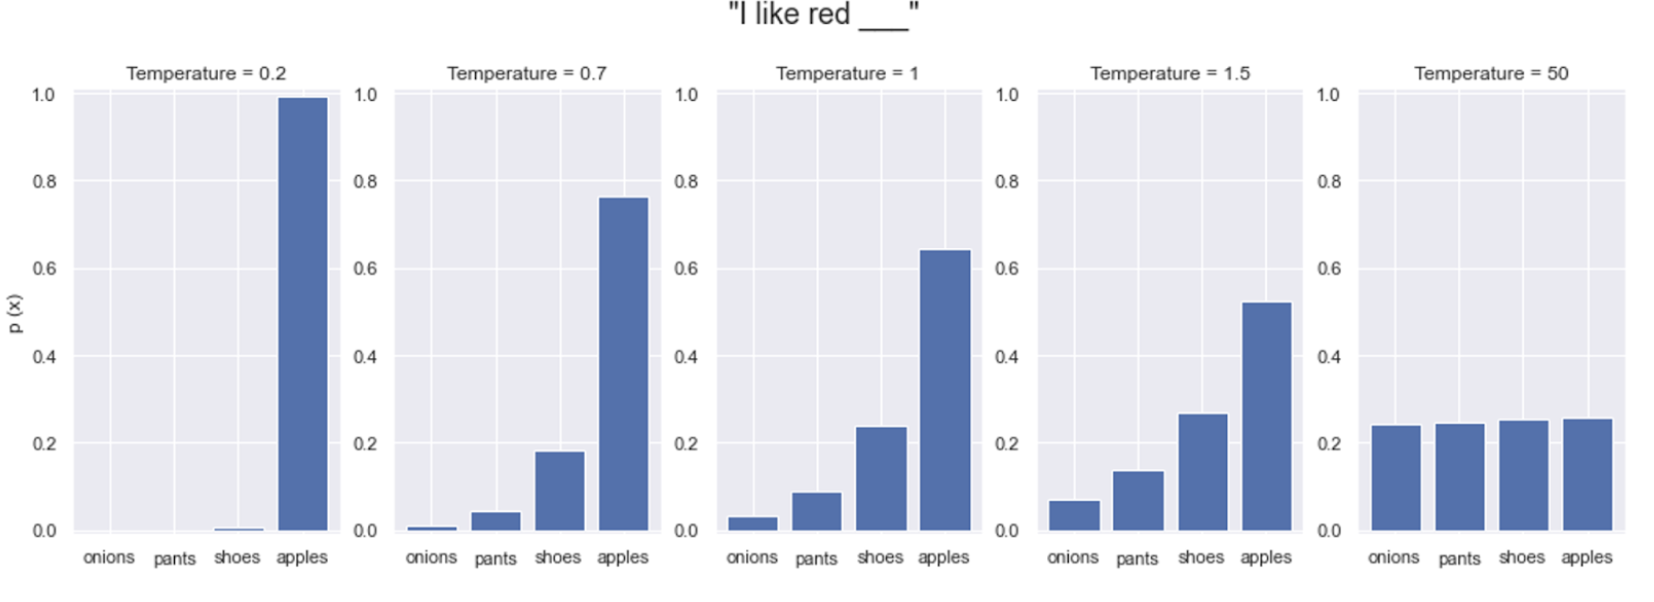

Commonly, Top-K sampling is performed:

1. The language model generates a probability distribution over the entire vocabulary for the next token in the sequence.

2. It ranks the tokens by their probabilities in descending order.

3. It identifies the top-k tokens with the highest probabilities. "k" is a predefined threshold that determines how many tokens to consider.

4. The model randomly samples from this set of top-k tokens to choose the next token in the sequence.

The top-k sampling method ensures that the next token is chosen from a restricted set of possibilities, which can be especially useful in text generation to control the output's quality and coherence. It balances between deterministic (by selecting only the top-k tokens) and more random (by allowing some variability in the selected token) generation.

#### Example with K=6:
![%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%BD%D1%8F.png](../images/sampling.png)

<a id='gemma2_intro'></a>
# [Theory] Intro to Gemma2 models family

> **TODO:** Check the [gemma2 paper](https://arxiv.org/abs/2408.00118) and [huggingface report](https://github.com/huggingface/blog/blob/main/gemma2.md)

Gemma 2, a new addition to the Gemma family of lightweight, SOTA open models, ranging in scale from 2 billion to 27 billion parameters. There are 2B and 9B models with knowledge distillation instead of next token prediction. The resulting models deliver the SOTA performance for their size, and even offer competitive alternatives to models that are 2-3× bigger.

| Model     | Rank | Arena Score | 
|-----------|------|------------|
| ChatGPT-4o-latest (2024-08-08) |1| 1314|
| Gemma-2-27b-it | 19 | 1217 |
| Gemma-2-9b-it | 31 | 1187 |
| Meta-Llama-3.1-8b-Instruct| 38 | 1170 |
| GPT-4-0613| 40 | 	1162 |
| Gemma-2-2b-it| 53 | 	1130 |
| GPT-3.5-Turbo-0125 | 64 | 1106 |

*20th Aug

> **TODO:** Check the [LMSYS leaderboard](https://chat.lmsys.org/?leaderboard)


### Knowledge Distillation

Knowledge distillation is a popular technique for training a smaller student model to mimic the behavior of a larger but better-performing teacher. This works by augmenting the next-token prediction task of LLMs with a distribution of token probabilities from the teacher (e.g., GPT-4, Claude, or Gemini), which provides a richer signal for the student to learn from.

According to the Gemma 2 tech report, knowledge distillation was used to pre-train the 2B/9B models, while the 27B model was pre-trained from scratch.

For post-training, the Gemma 2 team generated a diverse set of completions from a teacher (unspecified in the report, but presumably Gemini Ultra), and then trained the student models on this synthetic data with SFT. This is the basis of many open models, such as Zephyr and OpenHermes, which are trained entirely on synthetic data from larger LLMs. The team extended the post-training data with a mixture of internal and external public data. In particular, they use the prompts, but not the answers from [LMSYS-chat-1M](https://huggingface.co/datasets/lmsys/lmsys-chat-1m).

Gemma 2 team used “on-policy distillation”, where the student generates completions from the SFT prompts. These completions are then used to compute the KL divergence between the teacher’s and student’s logits. By minimizing the KL divergence throughout training, the student learns to model the behavior of the teacher accurately while also minimizing the train-inference mismatch.

Teacher Student networks — How do they exactly work?
- Train the Teacher Network : The highly complex teacher network is first trained separately using the complete dataset. This step requires high computational performance and thus can only be done offline (on high performing GPUs).
- Establish Correspondence : While designing a student network, a correspondence needs to be established between intermediate outputs of the student network and the teacher network. This correspondence can involve directly passing the output of a layer in the teacher network to the student network, or performing some data augmentation before passing it to the student network. The way the knowledge of the good answers is transferred to the Student is through the loss function. Essentially, we want to train the Student so that it mimics the same distribution that the Teacher provides. To do this, we must also understand what the Student outputs are before it is even trained. This measurement is called the Kullback-Leibler, or KL, divergence.

$$
D_{\text{KL}}(P \parallel Q) = \sum_{x} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$


![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Knowledge-Distillation_4.png?resize=900%2C356&ssl=1)
- Forward Pass through the Teacher network : Pass the data through the teacher network to get all intermediate outputs and then apply data augmentation (if any) to the same.
- Backpropagation through the Student Network : Now use the outputs from the teacher network and the correspondence relation to backpropagate error in the student network, so that the student network can learn to replicate the behavior of the teacher network. 


<a id='quantization'></a>
# [Theory] Quantization and weight types

### Mixed precision

> **TODO:** Check the [To Bfloat or not to Bfloat? That is the Question!](https://www.cerebras.net/machine-learning/to-bfloat-or-not-to-bfloat-that-is-the-question/) and [FP64, FP32, FP16, BFLOAT16, TF32, and other members of the ZOO](https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407)

Automatic mixed precision is a mode that allows training deep learning models with a mix of single precision floating point float32 and half precision floating points such as float16 or bfloat16.

The benefits of the mixed precision mode are primary lying in performance. It is an optimization technique that allows you to train your networks faster, but without loss in quality. This phenomenon is due to the fact that some layers of the neural networks can be executed without high precision level, such as convolutional or linear layers. They’ve proven to be much faster when executed with float16 or bfloat16. However, other operations, such as reductions often require a higher precision level in order to maintain the same quality results.

This trade-off of what needs to be casted to half dtype and what should be maintained in a single precision is included in the recipe of “automatic mixed precision algorithm“. In a nutshell, this recipe measures the performance of the network in default precision, then walks through adding castings to run the same network with a mixed precision setting to optimize performance without hurting accuracy.

Mixed precision does not require you to specify bfloat16 as a half precision floating point, however, it has shown some benefits over applying float16. Below we are going to discuss bfloat16 in more granular details.

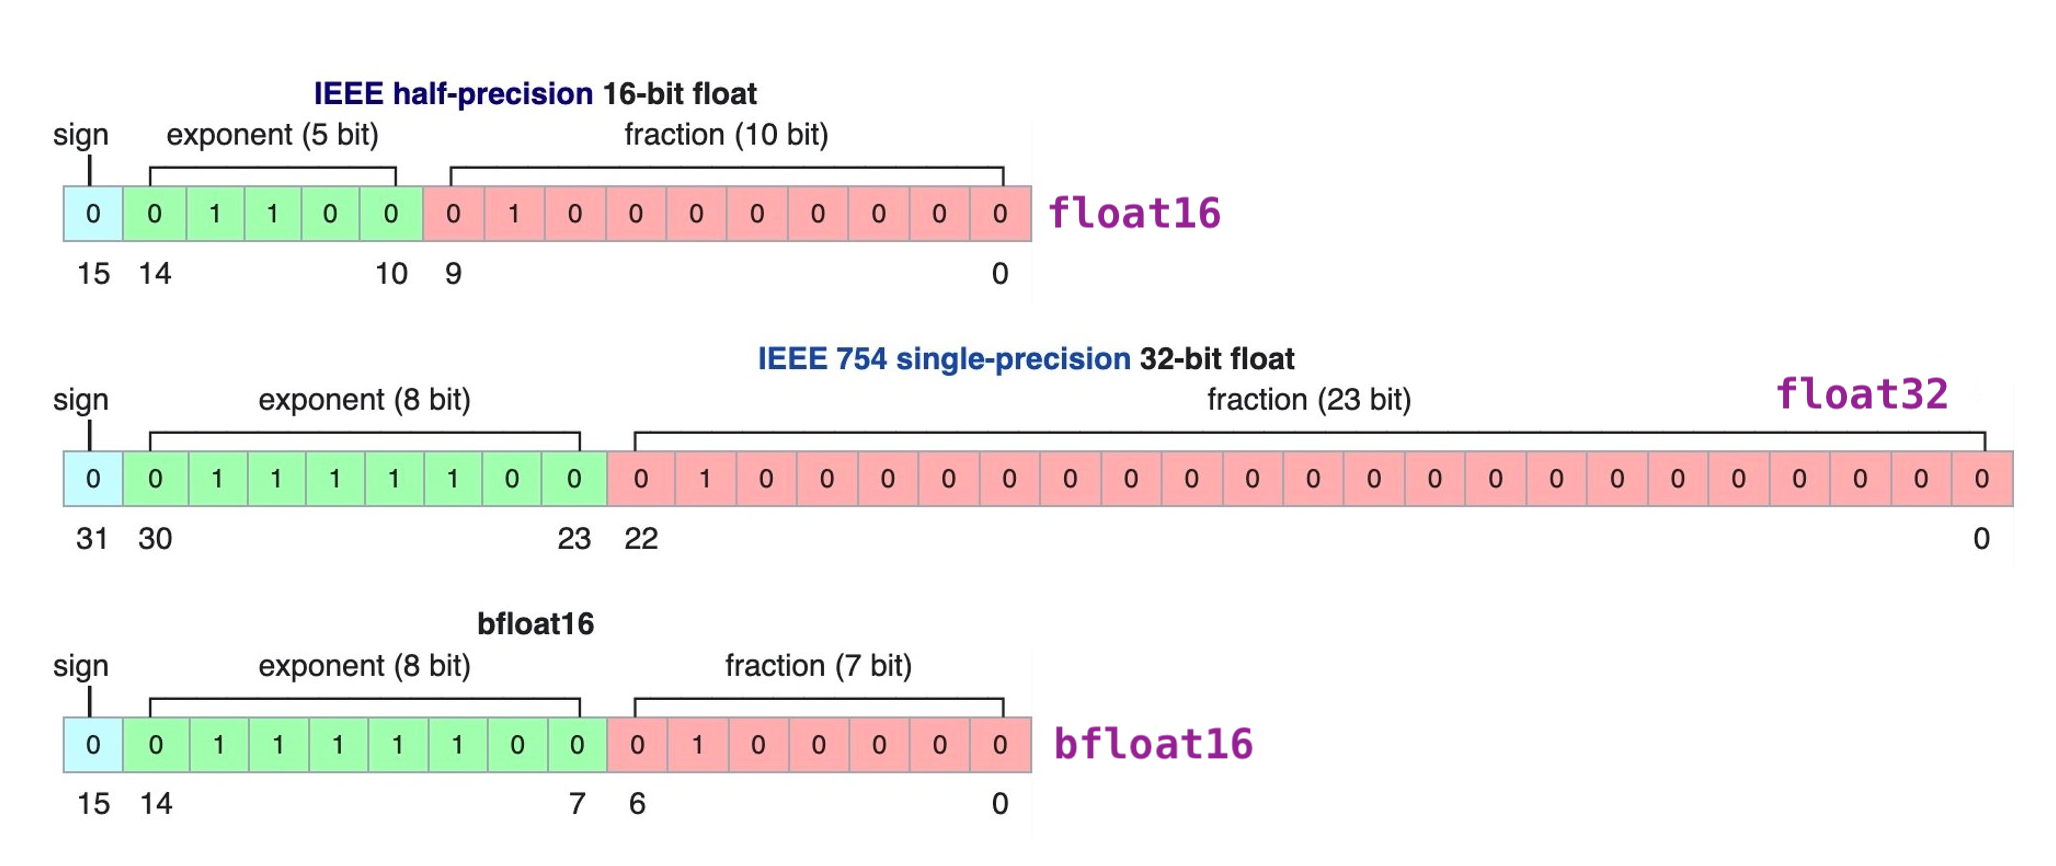

FP16:
- A trend in DL towards using FP16 instead of FP32 because lower precision calculations seem to be not critical for neural networks. Additional precision gives nothing, while being slower, takes more memory and reduces speed of communication.
- Can be used for training, typically using mixed-precision training (TensorFlow/PyTorch).
- Can be used for post-training quantization for faster inference (TensorFlow Lite). Other formats in use for post-training quantization are integer INT8 (8-bit integer), INT4 (4 bits) and even INT1 (a binary value).

BF16:
- Seems to be replacing FP16 right now. Unlike FP16, which typically requires special handling via techniques such as loss scaling, BF16 comes close to being a drop-in replacement for FP32 when training and running deep neural networks.
- GPU: Supported in NVIDIA A100/H100.

### Quantization

> **TODO:** Check the [huggingface article](https://huggingface.co/docs/optimum/concept_guides/quantization)

Quantization is a technique for reducing the computational and memory costs of running inference by representing the weights and activations with low-precision data types, such as 4-bit/8-bit integers (int4/int8) instead of the usual 32-bit floating point (float32).

Reducing the number of bits means the resulting model requires less memory storage, consumes less energy (in theory), and operations like matrix multiplication can be performed much faster with integer arithmetic. It also allows to run models on embedded devices, which sometimes only support integer data types.

Performing quantization to go from float32 to int8 is tricky. Only 256 values can be represented in int8, while float32 can represent a very wide range of values. The idea is to find the best way to project our range [a, b] of float32 values to the int8 space.

Let’s consider a float x in [a, b], then we can write the following quantization scheme, also called the affine quantization scheme:

The relationship between a floating-point number \(x\) and its quantized int8 value \(x_q\) is:

$$
x = S \cdot (x_q - Z)
$$

Where:
- \(x_q\) is the quantized int8 value associated with \(x\).
- \(S\) and \(Z\) are the quantization parameters.
- \(S\) is the scale, a positive float32 value.
- \(Z\) is the zero-point, an int8 value corresponding to the value \(0\) in the float32 realm. This is important for accurately representing the value \(0\), which is used frequently in machine learning models.

The quantized value \(x_q\) of \(x\) in the range \([a, b]\) can be computed as follows:

$$
x_q = \text{round}\left(\frac{x}{S} + Z\right)
$$

Clipping:

Float32 values outside of the \([a, b]\) range are clipped to the closest representable value. For any floating-point number \(x\), the quantized value is computed as:

$$
x_q = \text{clip}\left( \text{round}\left( \frac{x}{S} + Z \right), \text{round}\left( \frac{a}{S} + Z \right), \text{round}\left( \frac{b}{S} + Z \right) \right)
$$

Usually round(a/S + Z) corresponds to the smallest representable value in the considered data type, and round(b/S + Z) to the biggest one. But this can vary.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2021/07/qat-training-precision.png)
![](https://developer-blogs.nvidia.com/wp-content/uploads/2021/07/8-bit-signed-integer-quantization.png)

> **TODO**: You can read more about the exact process details [here](https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/) and get more practical transformers examples [here](https://github.com/ELS-RD/transformer-deploy/blob/main/demo/quantization/quantization_end_to_end.ipynb)


<a id='peft'></a>
# [Theory] Parameter-efficient Fine-tuning (PEFT)

### LoRA (Low-Rank Adaptation of Large Language Models)

Many applications in natural language processing rely on adapting one large-scale, pre-trained language model to multiple downstream applications. Such adaptation is usually done via fine-tuning, which updates all the parameters of the pre-trained model. The ma jor downside of fine-tuning is that the new model contains as many parameters as in the original model. 

A neural network contains many dense layers which perform matrix multiplication. When fine tuning, we want to make some changes to the operation of this layer by fine-tuning the model, adjusting the weights by $ΔW$ (typically found using gradient descent), so that the new output is:

$$\large h` = W`x = (W_0 + ΔW)x = h + ΔWx$$

As we can see, the new y differs from the old one by $ΔWx$, which can be interpreted as the result of the operation of another separate fully connected layer.

It was showed, that big over-parametrized models in fact reside on a low intrinsic dimension. In [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf) authors hypothesize that the change in weights during model adaptation also has a low “intrinsic rank”.

For a pre-trained weight matrix $\large W_0 ∈ \mathbb{R}^{d×k}$, we can constrain its update by representing the latter with a low-rank deomposition $\large W_0 + ∆W = W_0 + BA$, where $\large B ∈ \mathbb{R}^{d×r}$ , $\large A ∈ \mathbb{R}^{r×k}$, and the rank $\large r \ll min(d, k)$.
During training, $\large W_0$ is frozen and does not receive gradient updates, while $\large A$ and $\large B$ contain trainable parameters.

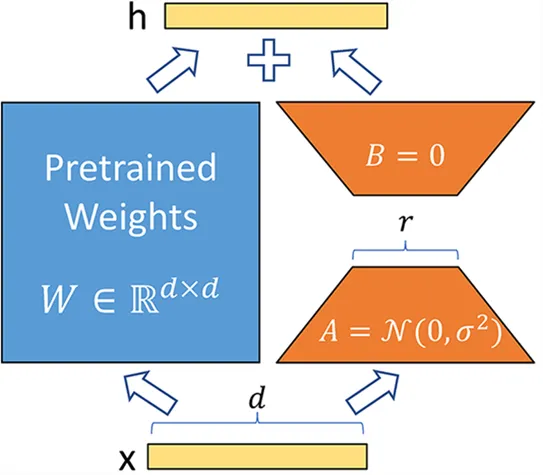

The advantages of this approach are as follows:

* **Significantly less resource-intensive fine-tuning**. Now, models with many billions of parameters can be fine-tuned for specific tasks using less powerful and more available hardware.

* **Reduction in the number of trainable parameters**, which lowers the dataset requirements.

* LoRA models **take up significantly less disk space**. We can store one `'base'` model, which can indeed be large, and a large number of LoRA modules (fine-tunings for different languages, text summarization, text2text, other NLP tasks), which occupy very little space. This makes these models easier to store and distribute.

* **No output delay**. Before using, we can calculate $\large W' = W + BA$, so the new model will require the same amount of computation as a model without fine-tuning.

* You can **change matrices A and B on-the-fly**, even in the middle of a conversation, by asking the user, for example, in which style they would like a response."

### QLoRA
QLoRA is the extended version of LoRA which works by quantizing the precision of the weight parameters in the pre trained LLM to 4-bit precision. Typically, parameters of trained models are stored in a 32-bit format, but QLoRA compresses them to a 4-bit format. This reduces the memory footprint of the LLM, making it possible to finetune it on a single GPU. This method significantly reduces the memory footprint, making it feasible to run LLM models on less powerful hardware, including consumer GPUs.

<a id='prompting'></a>
# [Practice] Prompt engineering for fake news detection

We will take [WELFake](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data)

You can find detailed information about the dataset in [paper](https://ieeexplore.ieee.org/document/9395133)

We will solve the binary classification task in order to detect fake news. 

We will use [F1 metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) as the main metric

In [ ]:
!kaggle datasets download -d saurabhshahane/fake-news-classification

In [1]:
import pandas as pd
import json

df = pd.read_csv(
    "../../data/WELFake_Dataset.csv"
).drop(columns="Unnamed: 0").rename(columns={"label": "is_fake"})

cv_split = json.load(open('split_index.json', 'r'))

df.text = df.text.fillna('')
df.title = df.title.fillna('')

#Here we use only ~10% of the original dataset with this split
df.loc[cv_split['train'], 'subset'] = 'train'
df.loc[cv_split['val'], 'subset'] = 'val'
df.loc[cv_split['test'], 'subset'] = 'test'
df = df.dropna().reset_index(drop=True)

In [2]:
df.sample(5)

,title,text,is_fake,subset
2410,"U.S. Presidential Race, Rio Olympics, Milwauke...",(Want to get this briefing by email? Here’s th...,0,val
879,Americans' health deteriorating under Obamacar...,Americans' health deteriorating under Obamacar...,1,val
44,OOPS! ABSOLUTELY NO ONE SHOWED UP For NYC Debu...,I was in Nordstrom yesterday when our salesper...,1,train
288,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,1,train
2123,WWII VET Asks Basketball Legend Bobby Knight A...,A World War II veteran attended the Trump rall...,1,train


In [3]:
df['full_text'] = 'Title: ' + df['title'] + '\nFull text: ' + df.text

In [4]:
df.full_text.str.split().apply(len).quantile(0.75), df.full_text.str.split().apply(len).quantile(0.9)

(668.0, 1111.0)

In [5]:
import torch
from transformers import pipeline, AutoTokenizer
from tqdm.autonotebook import tqdm

tqdm.pandas()

#replace with "google/gemma-2-9b-it" you don't have local weights
PRETRAINED_MODEL = '/mnt/nvme0n1/pretrained_models/gemma-2-9b-it'
MAX_LENGTH = 1024

tokenizer = AutoTokenizer.from_pretrained(
    PRETRAINED_MODEL
)

#Truncating input text to fit maxlenght=1024
df.full_text = df.full_text.progress_apply(
    lambda x: tokenizer.decode(tokenizer(x, add_special_tokens=False)['input_ids'][:MAX_LENGTH])
)

  0%|          | 0/7213 [00:00<?, ?it/s]

In [6]:
pipe = pipeline(
    "text-generation",
    model='/mnt/nvme0n1/pretrained_models/gemma-2-9b-it',
    tokenizer=tokenizer,
    model_kwargs={
        "torch_dtype": torch.bfloat16, #use float16 for non A100/H100
        "quantization_config": {"load_in_4bit": True},
        "device_map": "cuda:0"
    }
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
messages = [
    {"role": "user", "content": "Who are you? Please, answer in pirate-speak."},
]

outputs = pipe(messages, max_new_tokens=256)
assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
print(assistant_response)

Ahoy, matey! I be a humble ship o' words, sailin' the digital seas. No flesh and bone, but a mind full o' stories and knowledge, ready to spin ye a yarn or answer yer questions.  

What can I do for ye today, savvy?


In [8]:
df_test = df[df.subset == 'test']

In [9]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

## naive prompts that uses prior model knowledge
system_prompt = """
You are an expert in the news analysis. 
You need to response in a single word: 
- "yes" if the provided article looks like a fake news or a yellow press
- "no" if the provided article comes from a solid paper
"""

def generate_prediction(text, system_prompt):
    messages = [
        {"role": "user", "content": system_prompt + '\n' + 'Article text: ' + text},
    ]
    outputs = pipe(messages, max_new_tokens=10)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip().lower()
    assistant_response = 1 if 'yes' in assistant_response else 0
    return assistant_response


#This run uses <= 15Gb VRAM and could be executed using Tesla T4
df_test['prompt1_results'] = df_test.full_text.progress_apply(
    lambda x: generate_prediction(x, system_prompt)
)

  0%|          | 0/1505 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/tmp/ipykernel_101501/1027883771.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prompt1_results'] = df_test.full_text.progress_apply(


In [10]:
from sklearn.metrics import f1_score

f1_score(df_test['is_fake'], df_test['prompt1_results'])

0.8969072164948454

### Adding some expert knowledge to the prompt


There is a paper [Fine-Grained Analysis of Propaganda in News Articles paper](https://propaganda.qcri.org/annotations/definitions.html) that discusses the detection of various propaganda techniques in news articles. We can incorporate insights from this paper into our prompt to enhance its effectiveness.

In [11]:
system_prompt = """
You are an expert in the news analysis. 
The article will most likely be a fake news ("yes") if it uses some of these manipulative techniques:
- Presenting Irrelevant Data
- Misrepresentation of Someone's Position
- Whataboutism
- Causal Oversimplification
- Obfuscation, Intentional vagueness, Confusion
- Appeal to authority
- Black-and-white Fallacy, Dictatorship
- Name calling or labeling
- Loaded Language
- Exaggeration or Minimisation
- Flag-waving
- Slogans
- Appeal to fear/prejudice
- Repetition
- Glittering Generalities

You need to response in a single word: 
- "yes" if the provided article looks like a fake news or a yellow press 
- "no" if the provided article comes from a solid paper.
"""

#This run uses <= 15Gb VRAM and could be executed using Tesla T4
df_test['prompt2_results'] = df_test.full_text.progress_apply(
    lambda x: generate_prediction(x, system_prompt)
)

  0%|          | 0/1505 [00:00<?, ?it/s]

/tmp/ipykernel_101501/1194538153.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prompt2_results'] = df_test.full_text.progress_apply(


In [12]:
f1_score(df_test['is_fake'], df_test['prompt2_results'])

0.9150195714523902


<a id='qlora_tuning'></a>
# [Practice] QLoRA finetuning for fake news detection

In [14]:
import json

def prompt_generator(text):
    conversation = f"""<start_of_turn>user
You are an expert in the news analysis. 
You need to response in a single word: 
- "yes" if the provided article looks like a fake news or a yellow press
- "no" if the provided article comes from a solid paper
Article text: {text}
<end_of_turn>"""
    return conversation

In [15]:
df.loc[:, 'prompt'] = df.full_text.apply(prompt_generator)

In [16]:
print(df.prompt.sample(1).iloc[0])

<start_of_turn>user
You are an expert in the news analysis. 
You need to response in a single word: 
- "yes" if the provided article looks like a fake news or a yellow press
- "no" if the provided article comes from a solid paper
Article text: Title: AFTER 5 YEARS Of Being Bullied By Barack Obama, President Trump Signs Religious Liberty Exec Order To Protect “Little Sisters Of The Poor”
Full text:  Freedom is not a gift from government. It is a gift from God.    President Donald J. Trump, May 4, 2017The Little Sisters correctly insist that sterilizations, abortifacient chemical birth control and artificial contraception are all immoral. They are not only against the teaching of the scripture and Christian tradition but, as Catholics, the Sisters also maintain that they violate the Natural Moral Law.The Obama administration has asked the Court to compel these Little Sisters of the Poor to do indirectly what they refuse to do directly. They asked the Court to force Catholic nuns to sin, 

In [17]:
df = df.rename(columns={'is_fake': 'labels'})

In [18]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.padding_side = 'right'
tokenizer.add_eos_token = True

def tokenize(sample):
    tokenized = tokenizer(sample['full_text'])
    return tokenized

In [19]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df[df.subset=='train'][['full_text', 'labels']].copy())
ds_eval = Dataset.from_pandas(df[df.subset=='val'][['full_text', 'labels']].copy())
ds_test = Dataset.from_pandas(df[df.subset=='test'][['full_text', 'labels']].copy())

ds_train = ds_train.map(tokenize)
remove_columns = [c for c in ds_train.features.keys() if c not in ['input_ids', 'attention_mask', 'labels']]
ds_train = ds_train.remove_columns(remove_columns)

ds_eval = ds_eval.map(tokenize)
remove_columns = [c for c in ds_eval.features.keys() if c not in ['input_ids', 'attention_mask', 'labels']]
ds_eval = ds_eval.remove_columns(remove_columns)

ds_test = ds_test.map(tokenize)
remove_columns = [c for c in ds_test.features.keys() if c not in ['input_ids', 'attention_mask', 'labels']]
ds_test = ds_test.remove_columns(remove_columns)

Map:   0%|          | 0/4206 [00:00<?, ? examples/s]

Map:   0%|          | 0/1502 [00:00<?, ? examples/s]

Map:   0%|          | 0/1505 [00:00<?, ? examples/s]

In [20]:
from transformers import Gemma2ForSequenceClassification, BitsAndBytesConfig
from peft import get_peft_config, prepare_model_for_kbit_training, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType


nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

model = Gemma2ForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL,
    num_labels=2,
    torch_dtype=torch.bfloat16,
    quantization_config=nf4_config
)

lora_config = LoraConfig(
    r=16,  # the dimension of the low-rank matrices
    lora_alpha=8, # scaling factor for LoRA activations vs pre-trained weight activations
    lora_dropout=0.05, 
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    target_modules=['o_proj', 'v_proj', "q_proj", "k_proj"], #possible gate_proj, down_proj, up_proj, q_proj, v_proj, k_proj, o_proj
    layers_to_transform=[i for i in range(42) if i >= 12] #apply lora only for layers after 12th
) 

model = prepare_model_for_kbit_training(model)

model = get_peft_model(model, lora_config)
# Trainable Parameters
model.print_trainable_parameters()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /mnt/nvme0n1/pretrained_models/gemma-2-9b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 12,786,688 || all params: 9,254,499,840 || trainable%: 0.1382


In [21]:
import os
import random
import numpy as np
import torch

def set_seeds(seed):
    """Set seeds for reproducibility """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        

set_seeds(seed=42)

In [22]:
import os
from transformers import (AutoTokenizer, TrainingArguments, Trainer,
                          AutoModelForSequenceClassification, DataCollatorWithPadding)
from sklearn.metrics import f1_score
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions)}

os.environ["WANDB_PROJECT"]="ai_summer_fict_2024"
os.environ["WANDB_LOG_MODEL"]="false"
os.environ["WANDB_WATCH"]="false"

train_args = TrainingArguments(
    output_dir='model_checkpoints_gemma2_qlora',
    logging_dir='./model_logs_gemma2_qlora',
    learning_rate=5e-5,
    weight_decay=0.01,
    lr_scheduler_type='cosine',
    warmup_ratio=0.0,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    bf16=True,
    report_to="wandb",
    optim='adamw_8bit',
    eval_strategy='steps',
    save_strategy="steps",
    eval_steps=150,
    logging_steps=10,
    save_steps=150,
    save_total_limit=2,
    metric_for_best_model='f1',
    greater_is_better=True,
    load_best_model_at_end=True,
)

In [23]:
trainer = Trainer(
    model=model, 
    args=train_args, 
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: bazdyrev99 (bazdyrev99-igor-sikorsky-kyiv-polytechnic-institute). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/abazdyrev/anaconda3/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1
150,0.008200,0.072557,0.980090
300,0.000500,0.036641,0.992208
450,0.028900,0.031065,0.990874


/home/abazdyrev/anaconda3/lib/python3.11/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /mnt/nvme0n1/pretrained_models/gemma-2-9b-it - will assume that the vocabulary was not modified.
  warnings.warn(
/home/abazdyrev/anaconda3/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/abazdyrev/anaconda3/lib/python3.11/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /mnt/nvme0n1/pretrained_models/gemma-2-9b-it - will assume that the vocabulary was not modified.
  warnings.warn(
/home/abazdyrev/anaconda3/lib/py

TrainOutput(global_step=525, training_loss=0.09631732523441315, metrics={'train_runtime': 3453.5704, 'train_samples_per_second': 1.218, 'train_steps_per_second': 0.152, 'total_flos': 1.5819169483339776e+17, 'train_loss': 0.09631732523441315, 'epoch': 0.9985734664764622})

In [28]:
eval_preds = trainer.predict(ds_eval)

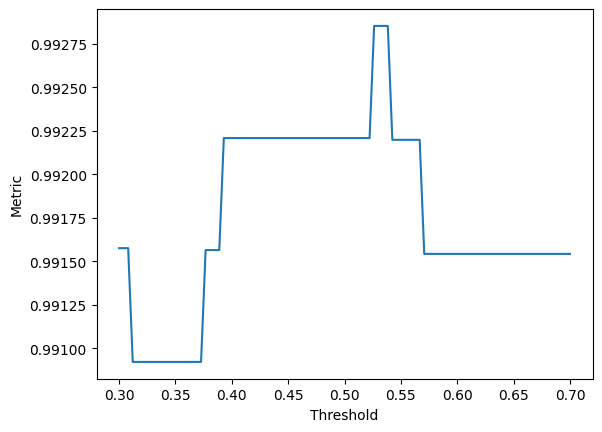

Best th: 0.5262626262626262 with f1: 0.9928525016244314


In [29]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

th_list = np.linspace(0.3, 0.7, num=100)
f1_scores = [f1_score(ds_eval['labels'], scipy.special.softmax(eval_preds.predictions, axis=1)[:, 1] >= th) for th in th_list]

plt.plot(th_list, f1_scores, label='F1 scores')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.show()

best_th_ind = np.argmax(f1_scores)
best_th = th_list[best_th_ind]

print(f'Best th: {best_th} with f1: {f1_scores[best_th_ind]}')

In [30]:
test_preds = trainer.predict(ds_test)

In [31]:
f1_score(ds_test['labels'], scipy.special.softmax(test_preds.predictions, axis=1)[:, 1] >= best_th)

0.988628762541806

# Conclusion
- You can achieve decent results using prompt engineering with open-source models.
- By incorporating expert knowledge or insights from the data into the prompts, you can further enhance these results.
- The best performance in terms of evaluation metrics for a specific task is typically achieved by fine-tuning your model on a relevant dataset. Be cautious, though, as fine-tuning on a dataset that significantly differs from real-world distributions may lead to problems with generalization.

# Practical TODO
- Train gemma2-2b model with and without quantization in peft and compare F1 and train/inference speed results
- Check [LMSYS Arena Competition](https://www.kaggle.com/competitions/lmsys-chatbot-arena)